In [51]:
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_rows', 1500)

from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import auc, f1_score, roc_curve, precision_recall_curve, classification_report
from sklearn.metrics import confusion_matrix, plot_precision_recall_curve, plot_roc_curve
from datetime import datetime
from src.data_functions import wrangle
w = wrangle()
from src.model_functions import thresh_selection, odds_to_prob
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
data = pd.read_csv('data/model/new_model_data.csv')

In [217]:
new_patients = data[(data['Tenure'] < 400)&(data['Recency'] < 400)]['PatNum']

In [218]:
data = data[~data['PatNum'].isin(new_patients)]

In [219]:
#test = data[data['Recency'] < 5000]
data = data[data['Recency'] < 2000]
#test.Tenure.describe(); data.Tenure.describe()

In [220]:
data['churn'] = np.where(data['Recency'] >= 400, 1, 0)
data['churn'].value_counts()/len(data) * 100

0    52.900811
1    47.099189
Name: churn, dtype: float64

In [221]:
drop_cols = ['PatNum', 'Recency', 'churn']

### Churn Distribution Plot

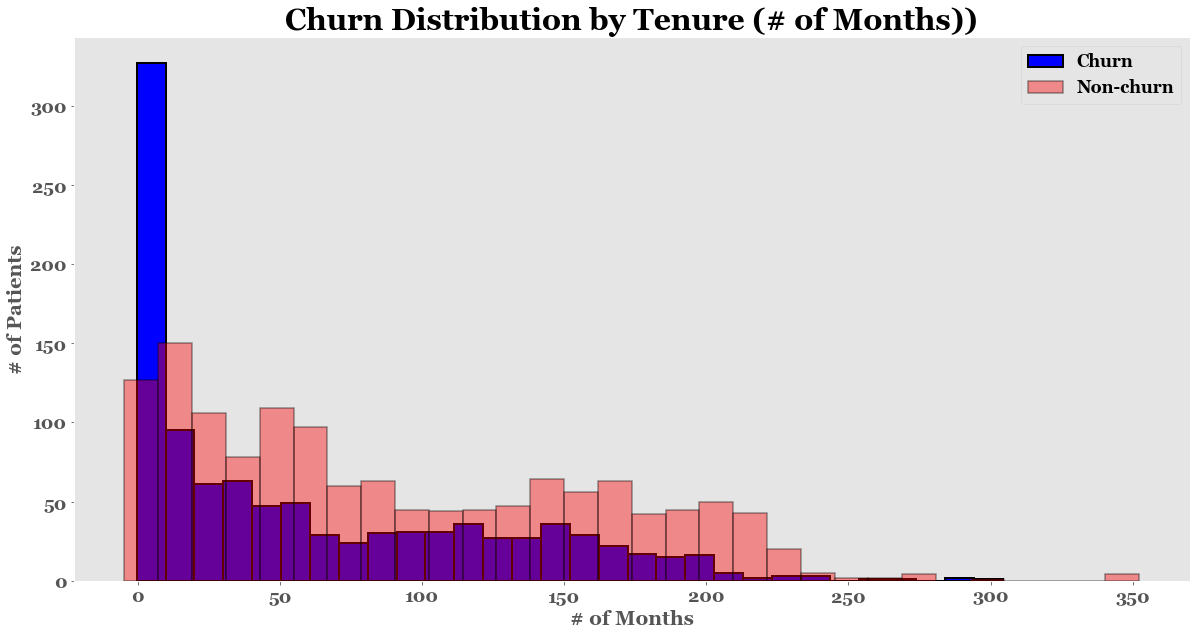

In [334]:
plt.style.use('ggplot')
tenure_non_churn = data[data['churn'] == 0]['tenure']/30
tenure_churn = data[data['churn'] == 1]['tenure']/30
hist_churn = plt.hist(tenure_churn, bins=30, edgecolor='black', lw=2, color='blue', label='Churn')
hist_non_churn = plt.hist(tenure_non_churn, bins=30, edgecolor='black', lw=1.5,color='red', alpha=0.4, label='Non-churn')
leg = plt.legend(fontsize='xx-large')
title = plt.title('Churn Distribution by Tenure (# of Months))', fontweight='bold', fontsize=30)
xlabel = plt.xlabel('# of Months', fontweight='bold', fontsize=20)
ylabel = plt.ylabel('# of Patients', fontweight='bold', fontsize=20)
xticks = plt.xticks(fontsize=18, fontweight='bold')
yticks = plt.yticks(fontsize=18, fontweight='bold')
plt.grid(False)

### Extract Label from data

In [222]:
X = data.drop(drop_cols, axis=1)
y = data.churn
X.shape, y.shape

((1603, 14), (1603,))

In [223]:
X

,Gender,EstBalance,InsEst,HasIns,age,seen_by_1,seen_by_2,seen_by_6,seen_by_7,seen_by_10,seen_by_15,Frequency,Tenure,Total
6,0,0.0,0.0,1,59.0,1,1,1,0,1,1,29,4737,3800.00
8,1,-4316.5,107.0,1,61.0,1,1,1,0,1,1,34,5227,10381.20
9,0,3938.1,0.0,1,72.0,1,1,1,0,1,0,57,5138,7250.90
11,0,-2197.2,0.0,1,56.0,1,1,1,1,1,1,38,4911,7325.20
14,0,-6955.5,0.0,0,79.0,1,1,0,0,1,1,35,5224,13904.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3173,1,-2593.0,0.0,1,58.0,1,1,1,1,0,1,32,5156,6728.98
3174,0,3877.3,0.0,1,72.0,1,1,1,0,1,1,50,4965,4725.70
3182,0,0.0,0.0,1,61.0,1,1,1,0,1,1,46,5157,16771.20
3185,1,0.0,0.0,1,56.0,1,1,1,0,0,1,31,4601,11553.98


In [224]:
# fit scaler on training data
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Create Train/Test split

In [225]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((1282, 14), (321, 14), (1282,), (321,))

In [174]:
cleanxtrain, cleanxtest, cleanytrain, cleanytest = train_test_split(Xclean, yclean, test_size = 0.2)
cleanxtrain.shape, cleanxtest.shape, cleanytrain.shape, cleanytest.shape

((1790, 20), (448, 20), (1790,), (448,))

In [226]:
lr = LogisticRegressionCV(solver='liblinear', penalty='l1', max_iter=500, scoring='recall')

In [227]:
# param_grid = {'penalty' : ['l1', 'l2'],
#               'Cs' : [10]}
# clf = GridSearchCV(lr, param_grid=param_grid, n_jobs=-1, cv=10, verbose=1, scoring='f1')

In [228]:
start = datetime.now()
lr.fit(xtrain, ytrain)
total = datetime.now() - start
print(f'{total/60} minutes of run time.')

LogisticRegressionCV(max_iter=500, penalty='l1', scoring='recall',
                     solver='liblinear')

0:00:00.001703 minutes of run time.


In [229]:
lr.score(xtest, ytest)

0.8159509202453987

In [230]:
predictions = lr.predict(xtest)
print(classification_report(ytest, predictions))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       158
           1       0.88      0.82      0.84       163

    accuracy                           0.85       321
   macro avg       0.85      0.85      0.85       321
weighted avg       0.85      0.85      0.85       321



In [218]:
def priority_list(original_df, predicted_probas, thresh):
    df = pd.DataFrame(predicted_probas).sort_values(1, ascending=False)
    inds = df[df[1] >= thresh].index
    patients = original_df.loc[inds, :].loc[:, ['PatNum', 'tenure', 'num_visits', 'LastVisit']]
    #patients = patients.sort_values(['LastVisit', 'tenure', 'num_visits'], ascending=[False, False, False])
    return patients


In [107]:
threshold = 0.48
predicted_proba = lr.predict_proba(xtest)
predicted = (predicted_proba [:,1] >= threshold).astype('int')
print(classification_report(ytest, predicted))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       168
           1       0.82      0.83      0.83       159

    accuracy                           0.83       327
   macro avg       0.83      0.83      0.83       327
weighted avg       0.83      0.83      0.83       327



In [147]:
confusion_matrix(ytest, predictions)

array([[143,  34],
       [ 24, 183]])

F1 Score at 0.2 prediction threshold: 0.84
False Positives = 66, False Negatives = 11


F1 Score at 0.22 prediction threshold: 0.84
False Positives = 65, False Negatives = 12


F1 Score at 0.24 prediction threshold: 0.84
False Positives = 62, False Negatives = 12


F1 Score at 0.26 prediction threshold: 0.84
False Positives = 59, False Negatives = 13


F1 Score at 0.28 prediction threshold: 0.84
False Positives = 56, False Negatives = 15


F1 Score at 0.3 prediction threshold: 0.85
False Positives = 51, False Negatives = 16


F1 Score at 0.32 prediction threshold: 0.86
False Positives = 46, False Negatives = 16


F1 Score at 0.34 prediction threshold: 0.86
False Positives = 45, False Negatives = 18


F1 Score at 0.36 prediction threshold: 0.86
False Positives = 44, False Negatives = 18


F1 Score at 0.38 prediction threshold: 0.86
False Positives = 44, False Negatives = 18


F1 Score at 0.4 prediction threshold: 0.86
False Positives = 41, False Negatives = 19


F1 Score at 0.42 predict

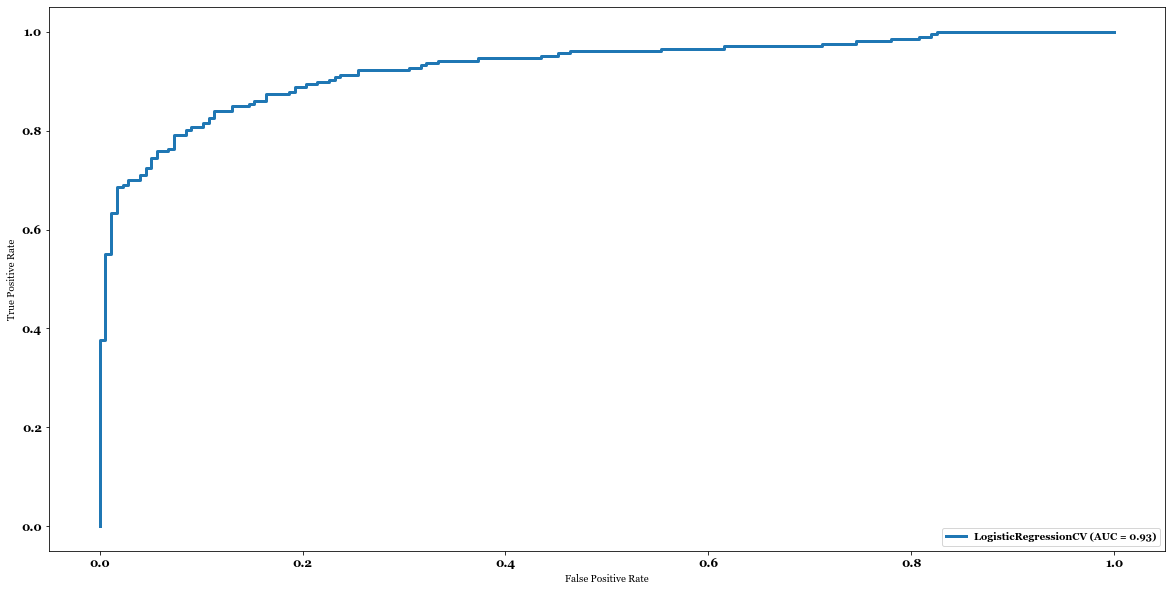

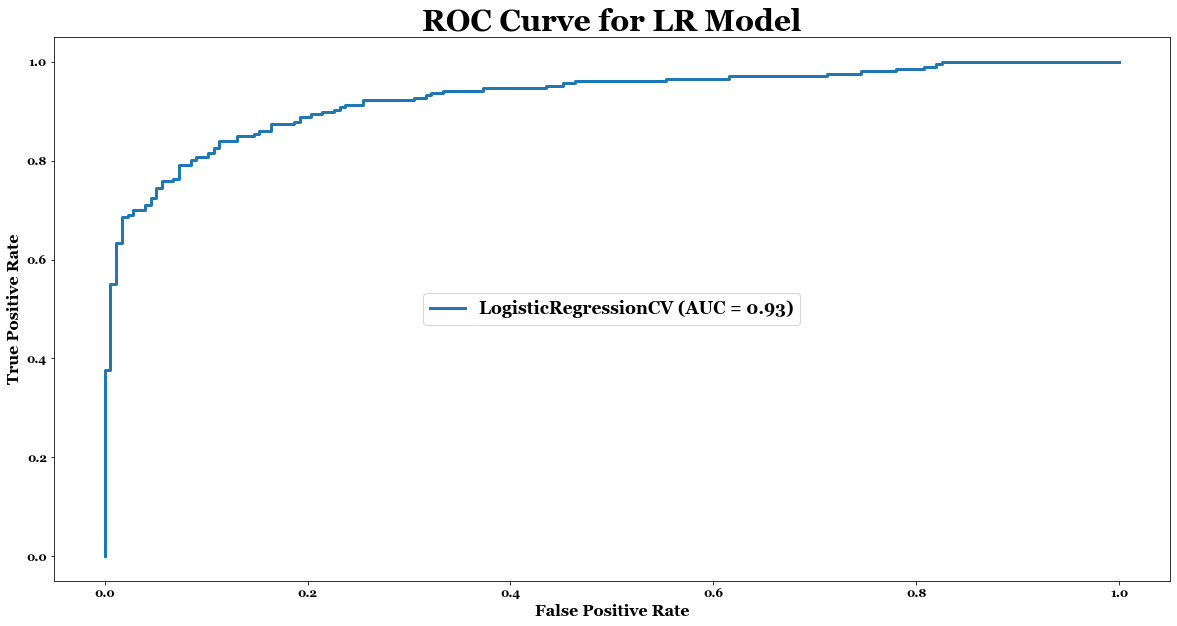

In [148]:
thresh_selection(xtest, ytest, lr, 0.2, 0.57, 0.02)
curve = plot_roc_curve(lr, xtest, ytest, lw=3)
title = plt.title('ROC Curve for LR Model', fontweight='bold', fontsize=30)
ylabel = plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
xlabel = plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
leg = plt.legend(fontsize='xx-large', loc=10)

### Save Model for Deployment

In [231]:
pickle_filename = "src/bestLRmodel.pkl"  

with open(pickle_filename, 'wb') as file:  
    pickle.dump(lr, file)

In [168]:
lr.predict_proba(test_dp.values)[0]

array([0.46525602, 0.53474398])

In [151]:
churn_pred = lr.predict(test_dp.values.reshape(1,-1))[0]
churn_proba = round(lr.predict_proba(test_dp.values.reshape(1,-1))[0][1]*100)
if churn_pred == 1:
    print(f'Patient is likely to churn with probability {churn_proba}%, you should do this...')

Patient is likely to churn with probability 69.0%, you should do this...


### Logistic Regression with statsmodel

In [109]:
log_reg = sm.Logit(ytrain, xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.395198
         Iterations 8


In [110]:
print(log_reg.summary(xname=X.columns.tolist()))

                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 1921
Model:                          Logit   Df Residuals:                     1896
Method:                           MLE   Df Model:                           24
Date:                Wed, 06 Jan 2021   Pseudo R-squ.:                  0.4216
Time:                        13:15:47   Log-Likelihood:                -759.18
converged:                       True   LL-Null:                       -1312.6
Covariance Type:            nonrobust   LLR p-value:                1.641e-218
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Gender          -0.0009      0.065     -0.014      0.989      -0.129       0.127
530_AreaCode    -0.0437      0.067     -0.654      0.513      -0.174       0.087
EstBalance       0.0736      0.068      1.08

In [111]:
np.exp(-0.9622 )

0.38205144754761716

In [60]:
print(log_reg.summary2(xname=X.columns.tolist()))

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.403      
Dependent Variable: churn            AIC:              1612.4011  
Date:               2021-01-06 12:31 BIC:              1751.4161  
No. Observations:   1921             Log-Likelihood:   -781.20    
Df Model:           24               LL-Null:          -1309.4    
Df Residuals:       1896             LLR p-value:      9.1302e-208
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Gender        -0.0633    0.0640   -0.9892  0.3226  -0.1886   0.0621
530_AreaCode   0.0102    0.0651    0.1559  0.8761  -0.1175   0.1378
EstBalance     0.1129    0.0688    1.6417  0.1006  -0.0219   0.2477
Bal_0_30      -

In [94]:
yhat = log_reg.predict(xtest)
predictions = list(map(round, yhat)) 

In [95]:
confusion_matrix(ytest, predictions)

array([[219,  47],
       [ 34, 181]])

In [96]:
print(classification_report(ytest, predictions))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84       266
           1       0.79      0.84      0.82       215

    accuracy                           0.83       481
   macro avg       0.83      0.83      0.83       481
weighted avg       0.83      0.83      0.83       481



In [140]:
coefs = pd.DataFrame().from_dict(dict(zip(X.columns, lr.coef_[0])), orient='index').sort_values(by=0)
coefs.rename(columns={0:'log_odds'}, inplace=True)

In [142]:
coefs['odds'] = np.exp(coefs['log_odds'])
coefs['probability'] = coefs.log_odds.apply(odds_to_prob)

In [143]:
coefs

,log_odds,odds,probability
num_visits,-1.281973,0.277489,0.217214
seen_by_10,-0.890760,0.410344,0.290953
InsEst,-0.740402,0.476922,0.322916
seen_by_15,-0.719637,0.486929,0.327473
seen_by_7,-0.492470,0.611115,0.379312
tenure,-0.230406,0.794211,0.442652
Bal_0_30,-0.210403,0.810258,0.447593
BalOver90,-0.188568,0.828144,0.452997
Zip_96073,-0.135139,0.873594,0.466267
child,-0.086936,0.916736,0.478280


In [322]:
gender = pd.read_csv('data/model_pat.csv')

In [325]:
gender.Gender.value_counts()/len(gender)

1    0.501249
0    0.498751
Name: Gender, dtype: float64

In [26]:
names = pd.read_csv('data/interm/patient_cleaned.csv', usecols=['PatNum', 'FName'])

In [35]:
names['FName'] = names['FName'].str[0].str.upper() + names['FName'].str[1:].str.lower() 

In [36]:
names = names.merge(data)

In [37]:
names.to_csv('data/model/with_names.csv', index=False)

In [42]:
names[names['PatNum'] == 6910]

,PatNum,FName,PatStatus,Gender,530_AreaCode,EstBalance,Bal_0_30,Bal_31_60,Bal_61_90,BalOver90,InsEst,BalTotal,HasIns,age,child,tenure,LastVisit,churn,num_visits,Zip_96001,Zip_96022,Zip_96073,Zip_96080,Zip_96099,seen_by_1,seen_by_10,seen_by_2,seen_by_15,seen_by_6,seen_by_7
827,6910,Jose antionio,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,36.0,0,1857,328,0,1,0,0,0,0,0,1,0,0,0,0,0


In [44]:
names['FName'].str.split()

['Paula']